In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import node2vec

import torch
import torch_geometric as tg

from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

## Read Data

### AIDS Data
https://networkrepository.com/AIDS.php

In [2]:
AIDS_EDGES = None
AIDS_LABELS = None

with open('data/AIDS/AIDS.edges.txt') as edges_file:
    AIDS_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=',')

with open('data/AIDS/AIDS.node_labels.txt') as nodes_file:
    AIDS_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    AIDS_LABELS = AIDS_LABELS[:, 1]

### FB CMU Data
https://networkrepository.com/fb-CMU-Carnegie49.php

In [3]:
FB_CMU_EDGES = None
FB_CMU_LABELS = None

with open('data/fb-CMU-Carnegie49/fb-CMU-Carnegie49.edges.txt') as edges_file:
    FB_CMU_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=' ')

with open('data/fb-CMU-Carnegie49/fb-CMU-Carnegie49.node_labels.txt') as nodes_file:
    FB_CMU_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    FB_CMU_LABELS = FB_CMU_LABELS[:, 1]

## Web Spam Detection Data
https://networkrepository.com/web-spam-detection.php

In [4]:
SPAM_EDGES = None
SPAM_LABELS = None

with open('data/web-spam-detection/web-spam-detection.edges.txt') as edges_file:
    SPAM_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=',')

with open('data/web-spam-detection/web-spam-detection.node_labels.txt') as nodes_file:
    SPAM_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    SPAM_LABELS = SPAM_LABELS[:, 1]

## Data Preprocessing

In [5]:
# X = AIDS_EDGES
# Y = AIDS_LABELS

X = FB_CMU_EDGES
Y = FB_CMU_LABELS

# X = SPAM_EDGES
# Y = SPAM_LABELS

In [6]:
G = nx.DiGraph()
G.add_edges_from(X)

In [7]:
EPOCHS = 1000
NUM_NODES = np.max(X)
NUM_CLASSES_CLUSTERS = np.max(Y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
data = tg.data.Data(
    x=torch.eye(NUM_NODES), 
    edge_index=torch.tensor(X-1, dtype=torch.long).t().contiguous(), 
    y=torch.nn.functional.one_hot(torch.tensor(Y-1, dtype=torch.long), NUM_CLASSES_CLUSTERS)).to(device)
    # y=torch.tensor(Y-1, dtype=torch.long)).to(device)

In [9]:
adjacency_matrix = np.zeros((NUM_NODES, NUM_NODES))
adjacency_matrix[X[:, 0]-1, X[:, 1]-1] = 1
adjacency_matrix[X[:, 1]-1, X[:, 0]-1] = 1

## Fully Connected Neural Network

In [10]:
class FCN(torch.nn.Module):
    def __init__(self, num_nodes, num_classes):
        super(FCN, self).__init__()
        self.fc1 = torch.nn.Linear(num_nodes, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)
        return x

In [11]:
model_fcn = FCN(NUM_NODES, NUM_CLASSES_CLUSTERS).to(device)
optimizer_fcn = torch.optim.Adam(model_fcn.parameters(), lr=0.1, weight_decay=5e-4)
loss_fn_fcn = torch.nn.MSELoss()

In [12]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(adjacency_matrix, Y, test_size=0.2, random_state=42)
X_TRAIN = torch.tensor(X_TRAIN, dtype=torch.float).to(device)
X_TEST = torch.tensor(X_TEST, dtype=torch.float).to(device)
Y_TRAIN = torch.nn.functional.one_hot(torch.tensor(Y_TRAIN-1, dtype=torch.long)).to(device)
Y_TEST = torch.nn.functional.one_hot(torch.tensor(Y_TEST-1, dtype=torch.long)).to(device)

In [13]:
loss_list_fcn = []
acc_list_fcn = []

for epoch in range(EPOCHS):
    model_fcn.train()
    optimizer_fcn.zero_grad()
    out = model_fcn(X_TRAIN)
    loss = loss_fn_fcn(out, Y_TRAIN.float())
    loss.backward()
    optimizer_fcn.step()

    model_fcn.eval()
    _, pred = model_fcn(X_TEST).max(dim=1)
    correct = float(pred.eq(Y_TEST.float().argmax(dim=1)).sum().item())
    acc = correct / len(Y_TEST)
    if (epoch+1) % 100 == 0:
        print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch+1, loss, acc))

    loss_list_fcn.append(loss.item())
    acc_list_fcn.append(acc)

Epoch: 100, Loss: 0.20365, Acc: 0.65738
Epoch: 200, Loss: 0.09784, Acc: 0.71461
Epoch: 300, Loss: 0.06441, Acc: 0.71611
Epoch: 400, Loss: 0.06875, Acc: 0.72816
Epoch: 500, Loss: 0.10089, Acc: 0.67696
Epoch: 600, Loss: 0.07604, Acc: 0.71762
Epoch: 700, Loss: 0.07635, Acc: 0.72364
Epoch: 800, Loss: 0.11163, Acc: 0.71235
Epoch: 900, Loss: 0.06360, Acc: 0.74548
Epoch: 1000, Loss: 0.08569, Acc: 0.74398


In [14]:
# test the model
model_fcn.eval()
_, pred = model_fcn(X_TEST).max(dim=1)
correct = float(pred.eq(Y_TEST.argmax(dim=1)).sum().item())
acc = correct / len(data.y)
print('Test Accuracy: {:.5f}'.format(acc))

Test Accuracy: 0.14886


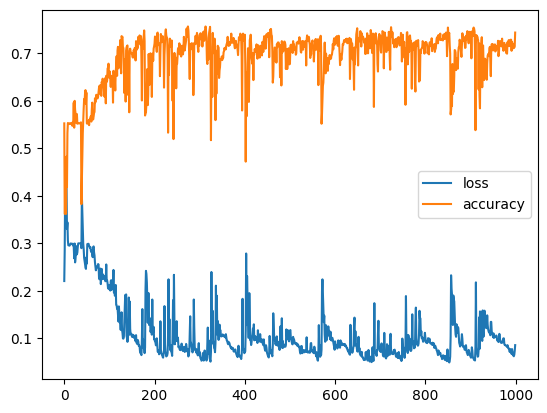

In [15]:
# plot loss and accuracy
plt.plot(loss_list_fcn)
plt.plot(acc_list_fcn)
plt.legend(['loss', 'accuracy'])
plt.show()

## Convolutional Neural Network

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, num_nodes, num_classes):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(128*10*10, 1024)
        self.fc2 = torch.nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128*10*10)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.softmax(self.fc2(x), dim=1)
        return x

In [ ]:
model_cnn = CNN(NUM_NODES, NUM_CLASSES_CLUSTERS).to(device)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.1, weight_decay=5e-4)
loss_fn_cnn = torch.nn.MSELoss()

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(adjacency_matrix, Y, test_size=0.2, random_state=42)
X_TRAIN = torch.tensor(X_TRAIN, dtype=torch.float).to(device)
X_TEST = torch.tensor(X_TEST, dtype=torch.float).to(device)
Y_TRAIN = torch.nn.functional.one_hot(torch.tensor(Y_TRAIN-1, dtype=torch.long)).to(device)
Y_TEST = torch.nn.functional.one_hot(torch.tensor(Y_TEST-1, dtype=torch.long)).to(device)

In [ ]:
X_TRAIN = X_TRAIN.view(-1, 1, 49, 49)
X_TEST = X_TEST.view(-1, 1, 49, 49)

dataset = torch.utils.data.TensorDataset(X_TRAIN, Y_TRAIN)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for epoch in range(EPOCHS):
    for data, label in dataloader:
        model_cnn.train()
        optimizer_cnn.zero_grad()
        out = model_cnn(data)
        loss = loss_fn_cnn(out, label.float())
        loss.backward()
        optimizer_cnn.step()
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch+1, loss))

In [ ]:
loss_list_cnn = []
acc_list_cnn = []

for epoch in range(EPOCHS):
    model_cnn.train()
    optimizer_cnn.zero_grad()
    out = model_cnn(X_TRAIN)
    loss = loss_fn_fcn(out, Y_TRAIN.float())
    loss.backward()
    optimizer_cnn.step()

    model_cnn.eval()
    _, pred = model_cnn(X_TEST).max(dim=1)
    correct = float(pred.eq(Y_TEST.float().argmax(dim=1)).sum().item())
    acc = correct / len(Y_TEST)
    if (epoch+1) % 100 == 0:
        print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch+1, loss, acc))

    loss_list_fcn.append(loss.item())
    acc_list_fcn.append(acc)

In [ ]:
# test the model
model_cnn.eval()
_, pred = model_cnn(X_TEST).max(dim=1)
correct = float(pred.eq(Y_TEST.argmax(dim=1)).sum().item())
acc = correct / len(data.y)
print('Test Accuracy: {:.5f}'.format(acc))

In [ ]:
# plot loss and accuracy
plt.plot(loss_list_cnn)
plt.plot(acc_list_cnn)
plt.legend(['loss', 'accuracy'])
plt.show()

## Graph Convolutional Network with 2 fully connected layers 

In [16]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, 1024)
        self.conv2 = tg.nn.GCNConv(1024, 256)
        self.conv3 = tg.nn.GCNConv(256, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        # x = torch.nn.functional.relu(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [17]:
model_gcn = GCN(num_node_features=NUM_NODES, num_classes=NUM_CLASSES_CLUSTERS).to(device)
optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn_gcn = torch.nn.CrossEntropyLoss()

In [18]:
loss_list_gcn = []
accuracy_list_gcn = []

for epoch in range(EPOCHS):
    model_gcn.train()
    optimizer_gcn.zero_grad()
    out = model_gcn(data)
    loss = loss_fn_gcn(out, data.y.float())
    loss.backward()
    optimizer_gcn.step()

    # validate the model
    model_gcn.eval()
    _, pred = model_gcn(data).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred.eq(true_labels).sum().item())
    acc = correct / len(data.y)
    loss_list_gcn.append(loss.item())
    accuracy_list_gcn.append(acc)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:03d}\t Loss: {loss:.4f}\t Val Acc: {acc:.4f}')

Epoch: 100	 Loss: 0.9004	 Val Acc: 0.6444
Epoch: 200	 Loss: 0.8481	 Val Acc: 0.7152
Epoch: 300	 Loss: 0.8418	 Val Acc: 0.7026
Epoch: 400	 Loss: 0.8309	 Val Acc: 0.7066
Epoch: 500	 Loss: 0.8197	 Val Acc: 0.7300
Epoch: 600	 Loss: 0.8436	 Val Acc: 0.7336
Epoch: 700	 Loss: 0.8167	 Val Acc: 0.7398
Epoch: 800	 Loss: 0.8226	 Val Acc: 0.7356
Epoch: 900	 Loss: 0.8330	 Val Acc: 0.7402
Epoch: 1000	 Loss: 0.8028	 Val Acc: 0.7603


In [19]:
# test the model
model_gcn.eval()
_, pred = model_gcn(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print(f'Test Acc: {acc:.4f}')

Test Acc: 0.7603


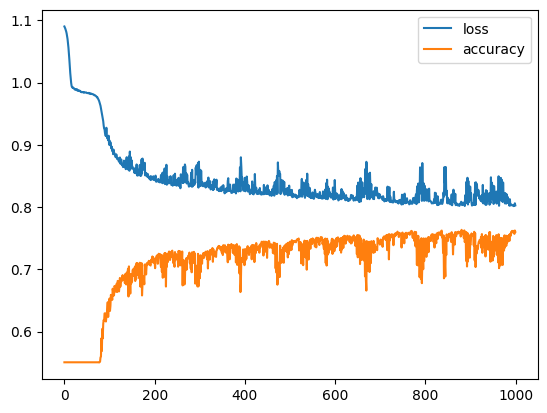

In [20]:
# plot loss and accuracy
plt.plot(loss_list_gcn)
plt.plot(accuracy_list_gcn)
plt.legend(['loss', 'accuracy'])
plt.show()

## Graph Encoder Embedding

In [ ]:
class GraphEncoderEmbedding(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphEncoderEmbedding, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_features, 256)
        self.conv2 = tg.nn.GCNConv(256, num_classes)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

In [ ]:
model = GraphEncoderEmbedding(num_features=NUM_NODES, num_classes=NUM_CLASSES_CLUSTERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
loss_list = []
accuracy_list = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.y.float())
    loss.backward()
    optimizer.step()

    # validate the model
    model.eval()
    _, pred = model(data.x, data.edge_index).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred.eq(true_labels).sum().item())
    acc = correct / len(data.y)
    loss_list.append(loss.item())
    accuracy_list.append(acc)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:03d}\t Loss: {loss:.4f}\t Val Acc: {acc:.4f}')

In [ ]:
# test the model
model.eval()
_, pred = model(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print(f'Test Acc: {acc:.4f}')

In [ ]:
# plot loss and accuracy
plt.plot(loss_list)
plt.plot(accuracy_list)
plt.legend(['loss', 'accuracy'])
plt.show()

## Spectral Embedding

In [21]:
embedding = SpectralEmbedding(n_components=NUM_NODES-10)  # 2D embedding
spectral_embedding = embedding.fit_transform(adjacency_matrix, Y)

In [22]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(spectral_embedding, Y, test_size=0.2, random_state=42)

In [23]:
lda_spectral = LinearDiscriminantAnalysis()
lda_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_LDA_SPECTRAL = lda_spectral.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_LDA_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_LDA_SPECTRAL)}")

print()
print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda_spectral.predict(X_TEST))}")

Training Accuracy LDA:
Accuracy: 0.9534752307402524
Adjusted Rand Index: 0.8477911163341735

Testing Accuracy LDA:
Accuracy: 0.4171686746987952
Adjusted Rand Index: 0.015540368552944946


In [24]:
qda_spectral = QuadraticDiscriminantAnalysis()
qda_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_QDA_SPECTRAL = qda_spectral.predict(X_TRAIN)

print("Training Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_QDA_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_QDA_SPECTRAL)}")

print()
print("Testing Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TEST == qda_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, qda_spectral.predict(X_TEST))}")

c:\Users\Maitri\Desktop\STAT622\.venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Training Accuracy QDA:
Accuracy: 1.0
Adjusted Rand Index: 1.0

Testing Accuracy QDA:
Accuracy: 0.27936746987951805
Adjusted Rand Index: 0.004288383393252093


In [25]:
kmeans_spectral = KMeans(n_clusters=NUM_CLASSES_CLUSTERS)
kmeans_spectral.fit(X_TRAIN)
Y_PRED_KMEANS_SPECTRAL = kmeans_spectral.predict(X_TRAIN)

print("Training Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TRAIN-1 == Y_PRED_KMEANS_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN-1, Y_PRED_KMEANS_SPECTRAL)}")

print()
print("Testing Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TEST-1 == kmeans_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST-1, kmeans_spectral.predict(X_TEST))}")

c:\Users\Maitri\Desktop\STAT622\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Accuracy KMeans:
Accuracy: 0.08118289696741382
Adjusted Rand Index: 0.00020723624806663144

Testing Accuracy KMeans:
Accuracy: 0.08509036144578314
Adjusted Rand Index: 0.0


In [26]:
svm_spectral = SVC()
svm_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_SVM_SPECTRAL = svm_spectral.predict(X_TRAIN)

print("Training Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_SVM_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_SVM_SPECTRAL)}")

print()
print("Testing Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TEST == svm_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, svm_spectral.predict(X_TEST))}")

Training Accuracy SVM:
Accuracy: 0.9009229610096063
Adjusted Rand Index: 0.7524198999260824

Testing Accuracy SVM:
Accuracy: 0.552710843373494
Adjusted Rand Index: 0.0


## Node2Vec

In [27]:
node2vec_model = node2vec.Node2Vec(G, dimensions=NUM_NODES-10, num_walks=200, workers=4)

model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv

node_ids = list(G.nodes())  # List of nodes in the graph
embedding_matrix = np.array([model.wv[str(node_id)] for node_id in node_ids])

Computing transition probabilities:   0%|          | 0/6637 [00:00<?, ?it/s]

In [28]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(embedding_matrix, Y, test_size=0.2, random_state=42)

In [29]:
lda_node = LinearDiscriminantAnalysis(n_components=2)
lda_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_LDA_NODE = lda_node.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_LDA_NODE) / len(Y)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_LDA_NODE)}")\

print()
print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda_node.predict(X_TEST))}")

Training Accuracy LDA:
Accuracy: 0.7875546180503239
Adjusted Rand Index: 0.9459251124980991

Testing Accuracy LDA:
Accuracy: 0.4066265060240964
Adjusted Rand Index: 0.0026503353041586308


In [30]:
qda_node = QuadraticDiscriminantAnalysis()
qda_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_QDA_NODE = qda_node.predict(X_TRAIN)

print("Training Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_QDA_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_QDA_NODE)}")

print()
print("Testing Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TEST == qda_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, qda_node.predict(X_TEST))}")

c:\Users\Maitri\Desktop\STAT622\.venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Training Accuracy QDA:
Accuracy: 0.8849124128837823
Adjusted Rand Index: 0.6479856689640899

Testing Accuracy QDA:
Accuracy: 0.48493975903614456
Adjusted Rand Index: -0.006673116127546364


In [31]:
kmeans_node = KMeans(n_clusters=NUM_CLASSES_CLUSTERS)
kmeans_node.fit(X_TRAIN)
Y_PRED_KMEANS_NODE = kmeans_node.predict(X_TRAIN)

print("Training Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TRAIN-1 == Y_PRED_KMEANS_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN-1, Y_PRED_KMEANS_NODE)}")

print()
print("Testing Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TEST-1 == kmeans_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST-1, kmeans_node.predict(X_TEST))}")

c:\Users\Maitri\Desktop\STAT622\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Accuracy KMeans:
Accuracy: 0.3829346392917687
Adjusted Rand Index: -0.0007052530827221361

Testing Accuracy KMeans:
Accuracy: 0.3810240963855422
Adjusted Rand Index: 0.0006103775998913788


In [32]:
svm_node = SVC()
svm_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_SVM_NODE = svm_node.predict(X_TRAIN)

print("Training Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_SVM_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_SVM_NODE)}")

print()
print("Testing Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TEST == svm_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, svm_node.predict(X_TEST))}")

Training Accuracy SVM:
Accuracy: 0.6677340365417216
Adjusted Rand Index: 0.1260498098734319

Testing Accuracy SVM:
Accuracy: 0.5504518072289156
Adjusted Rand Index: 0.003568533318545382
